# T_BANK_SIRIUS_RECSYS


## Выполнил Егоров Александр



>-----

## Комментарий к ноутбуку

Модели, и необходимые данные будут помещены в архивы 
candidates_*.zip, models_knn_pop.zip, model_ranker.zip. 

> Архивы с данными по выборкам, а так же candidates_full, model_lfm.zip не прилагается в github, т.к. его размер много больше 50 мб (git giant files issue). Их можно будет найти по следующим ссылкам:
>
> Данные по выборкам:
>> https://github.com/0x0000dead/sirius-tbank-recsys-task-2024 
> распаковать в папку data/ в корневой директории проекта, либо изменить путь до данных в ноутбуке
>
> Ссылка на гугл диск со всеми данными к ноутбукам:
>> https://drive.google.com/drive/folders/12WS-cT-jWI7aschIoPzquMcWTTmSbIum?usp=sharing
> модели распаковать в директорию models/,
> данные с кандидатами распаковать в в директорию models/models_data

Если ноутбук будет прогоняться и потребуется пропустить часть с обучением моделей, то указанные архивы необходимо разархивировать в соответствующие папки и прогнать ячейки с их импортами.


>----

# Библиотеки

In [1]:
import warnings
from tqdm.auto import tqdm

import dill
import shap

from typing import Dict, Any

import pandas as pd

import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightfm import LightFM

from lightgbm import LGBMRanker

from rectools import Columns
from rectools.dataset import Dataset as RTDataset

from rectools.models import (
    PopularModel,
    LightFMWrapperModel,
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


from rectools.models import implicit_knn
from implicit import nearest_neighbours

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

In [2]:
RANDOM_STATE = 42

# Метрики

In [3]:
# ACHTUNG! DO NOT TOUCH


def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(
            np.power(2, scores) - 1,
            np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2),
        ),
        dtype=np.float64,
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(
    df: pd.DataFrame, model_preds_col: str, gt_col: str = "movie_id"
) -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (
                ndcg_metric(row[gt_col], row[model_preds_col]),
                recall_metric(row[gt_col], row[model_preds_col]),
            )
        )

    return {
        "ndcg": np.mean([x[0] for x in metric_values]),
        "recall": np.mean([x[1] for x in metric_values]),
    }

# Данные

In [4]:
data_folder = "./data/"

users = pd.read_csv(data_folder + "users_df.csv")
items = pd.read_csv(data_folder + "items_df.csv")

countries = pd.read_csv(data_folder + "countries.csv")
genres = pd.read_csv(data_folder + "genres.csv")
staff = pd.read_csv(data_folder + "staff.csv")

interactions = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])
interactions = interactions.drop(columns=["is_train"])

test_df = pd.read_csv(data_folder + "test_data.csv")
test_df = test_df.groupby("user_id").agg({"movie_id": list}).reset_index()

## Посмотрим на данные в таблицах

In [5]:
def display_df_main_info(df: pd.DataFrame):
    display(df.head(5))
    display(df.shape)
    display(df.dtypes)

In [6]:
display_df_main_info(users)

,user_id,age_category,income,sex,kids_flg,education
0,10250,35-44,NaN,NaN,0.0,Высшее
1,2062,18-24,NaN,Женский,0.0,Среднее
2,12980,35-44,NaN,Женский,1.0,Неполное высшее
3,30646,35-44,низкий,NaN,1.0,Высшее
4,43069,25-34,NaN,Женский,NaN,Высшее


(207377, 6)

user_id           int64
age_category     object
income           object
sex              object
kids_flg        float64
education        object
dtype: object

In [7]:
display_df_main_info(items)

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,NaN
1,1,Три метра над уровнем неба,2010-01-01,NaN,"История любви парня и девушки, принадлежащих к...","[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 268...",Tres metros sobre el cielo,16.0,"Три, метра, над, уровнем, неба, 2010, Испания,..."
2,2,Детектив ди и тайна призрачного пламени,2010-01-01,NaN,"690 год нашей эры, Китай. Первая императрица д...","[294, 302]","[250, 117]","[3933, 19953, 32174, 30640, 14127, 32141, 2549...",NaN,NaN,NaN
3,3,Капитан,2017-01-01,2022-10-20T00:00:00,Вторая мировая война подходит к концу. В это в...,"[97, 303, 143, 319]","[188, 212, 0]","[16006, 12217, 30668, 28806, 16172, 5045, 1663...",NaN,NaN,NaN
4,4,Лазурный берег,2015-01-01,2023-01-12T00:00:00,У бывшей танцовщицы Ванессы и писателя Роланда...,"[138, 97]","[1, 102, 0]","[23586, 8823, 8040, 34555, 32484, 18446]",By the Sea,18.0,"Франция, отель, 1970-е, горе, путешествие, нес..."


(7427, 11)

id                    int64
title                object
year                 object
date_publication     object
description          object
genres               object
countries            object
staff                object
title_orig           object
age_rating          float64
keywords             object
dtype: object

In [8]:
display_df_main_info(interactions)

,id,datetime,user_id,movie_id,duration
0,0,2023-04-06 15:00:00.071114+03:00,10250,427.0,485.0
1,1,2023-04-06 15:00:01.123928+03:00,2062,1521.0,129.0
2,2,2023-04-06 15:00:03.957246+03:00,12980,4598.0,2795.0
3,3,2023-04-06 15:00:04.990565+03:00,30646,5324.0,5094.0
4,4,2023-04-06 15:00:10.495017+03:00,43069,4291.0,75.0


(1251871, 5)

id            int64
datetime     object
user_id       int64
movie_id    float64
duration    float64
dtype: object

In [9]:
display_df_main_info(countries)
display_df_main_info(genres)
display_df_main_info(staff)

,id,name
0,0,Франция
1,1,Мальта
2,5,Новая Зеландия
3,8,Куба
4,10,Пуэрто-Рико


(100, 2)

id       int64
name    object
dtype: object

,id,name
0,2,Сказка
1,8,Здоровье
2,17,Наука
3,24,Комедийная мелодрама
4,38,Мистика


(96, 2)

id       int64
name    object
dtype: object

,id,name,role
0,0,Юрий Волынцев,actor
1,1,Коннор Смит,actor
2,2,Майкл Гандольфини,actor
3,3,Майкл Маркс,producer
4,4,Кад Мерад,actor


(35684, 3)

id       int64
name    object
role    object
dtype: object

In [10]:
display(interactions.head(2))
display(interactions.shape)

,id,datetime,user_id,movie_id,duration
0,0,2023-04-06 15:00:00.071114+03:00,10250,427.0,485.0
1,1,2023-04-06 15:00:01.123928+03:00,2062,1521.0,129.0


(1251871, 5)

In [11]:
display(test_df.head(2))
display(test_df.shape)

,user_id,movie_id
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215...."


(66900, 2)

# Предобработка данных

## Interactions

In [12]:
interactions["datetime"] = pd.to_datetime(
    interactions["datetime"],
    format="ISO8601",
)
interactions["movie_id"] = interactions["movie_id"].apply(np.int64)
interactions["duration"] = interactions["duration"].apply(np.int64)
interactions = interactions.drop(columns=["id"])


display(interactions.head(2))

,datetime,user_id,movie_id,duration
0,2023-04-06 15:00:00.071114+03:00,10250,427,485
1,2023-04-06 15:00:01.123928+03:00,2062,1521,129


### Наблюдение

Сопоставляя колонку duration с реальной продолжительностью фильма, найденной с помощью поисковика, можно заключить, что duration - это количество секунд, которые пользователь провел за просмотром фильма. 

> Средняя продолжительность фильма составляет от 90 до 120 минут (от 5400 до 7200 секунд). 

$$
    avg\_time = \dfrac{90 + 120}{2}\ \text{мин} = 105\ \text{мин} = 6300\ \text{с}
$$


Добавим эвристику (условный процент просмотра): 

$$
    watched\_pct = \dfrac{duration}{avg\_time}
$$


In [13]:
interactions["watched_pct"] = interactions["duration"] / 6300
interactions.head(3)

,datetime,user_id,movie_id,duration,watched_pct
0,2023-04-06 15:00:00.071114+03:00,10250,427,485,0.076984
1,2023-04-06 15:00:01.123928+03:00,2062,1521,129,0.020476
2,2023-04-06 15:00:03.957246+03:00,12980,4598,2795,0.443651


In [14]:
# Переименовываем колонки
interactions = interactions.rename(
    columns={
        "watched_pct": Columns.Weight,
        "datetime": Columns.Datetime,
        "movie_id": "item_id",
    }
)

In [15]:
interactions["datetime"].isna().unique(), interactions["weight"].isna().unique()

(array([False]), array([False]))

In [16]:
interactions.dtypes

datetime    datetime64[ns, UTC+03:00]
user_id                         int64
item_id                         int64
duration                        int64
weight                        float64
dtype: object

## Users

In [17]:
users

,user_id,age_category,income,sex,kids_flg,education
0,10250,35-44,NaN,NaN,0.0,Высшее
1,2062,18-24,NaN,Женский,0.0,Среднее
2,12980,35-44,NaN,Женский,1.0,Неполное высшее
3,30646,35-44,низкий,NaN,1.0,Высшее
4,43069,25-34,NaN,Женский,NaN,Высшее
...,...,...,...,...,...,...
207372,224150,45-54,средний,Женский,1.0,Высшее
207373,227931,35-44,NaN,NaN,1.0,NaN
207374,143732,18-24,NaN,Женский,0.0,Среднее
207375,58404,25-34,низкий,Женский,1.0,Среднее


In [18]:
display(users["user_id"].isna().unique())
display(users["age_category"].isna().unique())
display(users["income"].isna().unique())
display(users["sex"].isna().unique())
display(users["kids_flg"].isna().unique())
display(users["education"].isna().unique())

array([False])

array([False,  True])

array([ True, False])

array([ True, False])

array([False,  True])

array([False,  True])

In [19]:
# Заполняем пропуски
users_default_values: Dict[str, Any] = {
    "age_category": "unknown",
    "income": "unknown",
    "sex": "unknown",
    "kids_flg": -1,
    "education": "unknown",
}
users.fillna(users_default_values, inplace=True)

In [20]:
display(users["income"].unique())
display(users["sex"].unique())
display(users["kids_flg"].unique())
display(users["education"].unique())

array(['unknown', 'низкий', 'средний', 'высокий', 'очень высокий'],
      dtype=object)

array(['unknown', 'Женский', 'Мужской'], dtype=object)

array([ 0.,  1., -1.])

array(['Высшее', 'Среднее', 'Неполное высшее', 'Без образования',
       'unknown'], dtype=object)

In [21]:
users["kids_flg"] = users["kids_flg"].apply(np.int8)
users

,user_id,age_category,income,sex,kids_flg,education
0,10250,35-44,unknown,unknown,0,Высшее
1,2062,18-24,unknown,Женский,0,Среднее
2,12980,35-44,unknown,Женский,1,Неполное высшее
3,30646,35-44,низкий,unknown,1,Высшее
4,43069,25-34,unknown,Женский,-1,Высшее
...,...,...,...,...,...,...
207372,224150,45-54,средний,Женский,1,Высшее
207373,227931,35-44,unknown,unknown,1,unknown
207374,143732,18-24,unknown,Женский,0,Среднее
207375,58404,25-34,низкий,Женский,1,Среднее


In [22]:
users.dtypes

user_id          int64
age_category    object
income          object
sex             object
kids_flg          int8
education       object
dtype: object

In [23]:
cat_user_features = [
    "age_category",
    "income",
    "sex",
    "education",
    "kids_flg",
]

user_cat_encoder = OrdinalEncoder(dtype=np.int64)
users[cat_user_features] = user_cat_encoder.fit_transform(users[cat_user_features])

display(users)

,user_id,age_category,income,sex,kids_flg,education
0,10250,2,0,0,1,2
1,2062,0,0,1,1,4
2,12980,2,0,1,2,3
3,30646,2,2,0,2,2
4,43069,1,0,1,0,2
...,...,...,...,...,...,...
207372,224150,3,4,1,2,2
207373,227931,2,0,0,2,0
207374,143732,0,0,1,1,4
207375,58404,1,2,1,2,4


In [24]:
users.dtypes

user_id         int64
age_category    int64
income          int64
sex             int64
kids_flg        int64
education       int64
dtype: object

## Items

In [25]:
items.head(2)

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,NaN
1,1,Три метра над уровнем неба,2010-01-01,NaN,"История любви парня и девушки, принадлежащих к...","[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 268...",Tres metros sobre el cielo,16.0,"Три, метра, над, уровнем, неба, 2010, Испания,..."


In [26]:
items = items.rename(
    columns={
        "id": "item_id",
    }
)

### Genres

In [27]:
items["genres"].isna().unique(), items["countries"].isna().unique()

(array([False]), array([False]))

In [28]:
genre_feature = items[["item_id", "genres"]]
genre_feature["genres"] = (
    genre_feature["genres"]
    .str.replace("\[", "", regex=True)
    .str.replace("\]", "", regex=True)
    .str.split(", ")
)
genre_feature.head()

,item_id,genres
0,0,[97]
1,1,"[138, 97, 294]"
2,2,"[294, 302]"
3,3,"[97, 303, 143, 319]"
4,4,"[138, 97]"


Выберем 3 главных жанра описывающих фильм

In [29]:
def select_n(x, n):
    try:
        if np.array(x)[n] == "":
            return "-1000"
        return np.array(x)[n]
    except:
        if np.array(x)[0] == "":
            return "-1000"
        return np.array(x)[0]

In [30]:
for i in range(3):
    items[f"genre_{i}"] = genre_feature["genres"]
    items[f"genre_{i}"] = items[f"genre_{i}"].apply(lambda x: np.int64(select_n(x, i)))

items.head(3)

,item_id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords,genre_0,genre_1,genre_2
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,NaN,97,97,97
1,1,Три метра над уровнем неба,2010-01-01,NaN,"История любви парня и девушки, принадлежащих к...","[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 268...",Tres metros sobre el cielo,16.0,"Три, метра, над, уровнем, неба, 2010, Испания,...",138,97,294
2,2,Детектив ди и тайна призрачного пламени,2010-01-01,NaN,"690 год нашей эры, Китай. Первая императрица д...","[294, 302]","[250, 117]","[3933, 19953, 32174, 30640, 14127, 32141, 2549...",NaN,NaN,NaN,294,302,294


#### Countries

In [31]:
country_feature = items[["item_id", "countries"]]
country_feature["countries"] = (
    country_feature["countries"]
    .str.replace("\[", "", regex=True)
    .str.replace("\]", "", regex=True)
    .str.split(", ")
)
country_feature.head()

,item_id,countries
0,0,[238]
1,1,[242]
2,2,"[250, 117]"
3,3,"[188, 212, 0]"
4,4,"[1, 102, 0]"


Выберем 3 главных страны описывающих фильм

In [32]:
for i in range(3):
    items[f"country_{i}"] = country_feature["countries"]
    items[f"country_{i}"] = items[f"country_{i}"].apply(
        lambda x: np.int64(select_n(x, i))
    )

items.head(3)

,item_id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords,genre_0,genre_1,genre_2,country_0,country_1,country_2
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,NaN,97,97,97,238,238,238
1,1,Три метра над уровнем неба,2010-01-01,NaN,"История любви парня и девушки, принадлежащих к...","[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 268...",Tres metros sobre el cielo,16.0,"Три, метра, над, уровнем, неба, 2010, Испания,...",138,97,294,242,242,242
2,2,Детектив ди и тайна призрачного пламени,2010-01-01,NaN,"690 год нашей эры, Китай. Первая императрица д...","[294, 302]","[250, 117]","[3933, 19953, 32174, 30640, 14127, 32141, 2549...",NaN,NaN,NaN,294,302,294,250,117,250


### Staff

In [33]:
staff_feature = items[["item_id", "staff"]]
staff_feature["staff"] = (
    staff_feature["staff"]
    .str.replace("\[", "", regex=True)
    .str.replace("\]", "", regex=True)
    .str.split(", ")
)
staff_feature["staff"] = staff_feature["staff"].apply(
    lambda x: np.array(
        [id if id != "" else "-1000" for id in x],
        dtype=np.int64,
    )
)
staff_feature.head()

,item_id,staff
0,0,"[1883, 33655, 25890, 1001, 12051, 10110, 16895]"
1,1,"[18168, 23444, 10850, 21847, 30555, 24469, 268..."
2,2,"[3933, 19953, 32174, 30640, 14127, 32141, 2549..."
3,3,"[16006, 12217, 30668, 28806, 16172, 5045, 1663..."
4,4,"[23586, 8823, 8040, 34555, 32484, 18446]"


Выберем 5 участников staff описывающих фильм

Выберем 3 актера, 1 продюссера и 1 режисера

In [34]:
staff["role"].unique()

array(['actor', 'producer', 'editor', 'director', 'writer', 'composer',
       'presenter', 'commentator'], dtype=object)

In [35]:
actors_ids = staff.loc[staff["role"] == "actor"]["id"].values
directors_ids = staff.loc[staff["role"] == "director"]["id"].values
producer_ids = staff.loc[staff["role"] == "producer"]["id"].values


roles_ids = {
    "actor": actors_ids,
    "director": directors_ids,
    "producer": producer_ids,
}


def select_staff_by_role(x, n: int = 3, role_name: str = "actor"):
    ids = np.array([-1000 for _ in range(n)], dtype=np.int64)
    counter = 0
    for i in range(len(x)):
        if x[i] in roles_ids[role_name]:
            ids[counter] = x[i]
            counter += 1
            if counter == n:
                break
    return ids

In [36]:
items["actor"] = staff_feature["staff"].apply(
    lambda x: select_staff_by_role(x, n=3, role_name="actor")
)
items["director"] = staff_feature["staff"].apply(
    lambda x: select_staff_by_role(x, n=1, role_name="director")
)
items["producer"] = staff_feature["staff"].apply(
    lambda x: select_staff_by_role(x, n=1, role_name="producer")
)

for n, role in zip((3, 1, 1), ("actor", "director", "producer")):
    for i in range(n):
        items[f"{role}_{i}"] = items[f"{role}"]
        items[f"{role}_{i}"] = items[f"{role}_{i}"].apply(lambda x: x[i])

items.head(3)

,item_id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,...,country_1,country_2,actor,director,producer,actor_0,actor_1,actor_2,director_0,producer_0
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,...,238,238,"[1883, 33655, 25890]",[-1000],[-1000],1883,33655,25890,-1000,-1000
1,1,Три метра над уровнем неба,2010-01-01,NaN,"История любви парня и девушки, принадлежащих к...","[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 268...",Tres metros sobre el cielo,16.0,...,242,242,"[18168, 23444, 10850]",[7053],[-1000],18168,23444,10850,7053,-1000
2,2,Детектив ди и тайна призрачного пламени,2010-01-01,NaN,"690 год нашей эры, Китай. Первая императрица д...","[294, 302]","[250, 117]","[3933, 19953, 32174, 30640, 14127, 32141, 2549...",NaN,NaN,...,117,250,"[3933, 32174, 30640]",[17540],[31229],3933,32174,30640,17540,31229


### Year

In [37]:
items["year"].isna().unique(), items["year"].values

(array([False]),
 array(['2022-01-01', '2010-01-01', '2010-01-01', ..., '2017-01-01',
        '2023-01-01', '2012-01-01'], dtype=object))

В формат datetime и оставить только год

In [38]:
items["year"] = pd.to_datetime(items["year"]).apply(lambda x: x.year)

Выберем 3 главных жанра описывающих фильм

In [39]:
items.columns

Index(['item_id', 'title', 'year', 'date_publication', 'description', 'genres',
       'countries', 'staff', 'title_orig', 'age_rating', 'keywords', 'genre_0',
       'genre_1', 'genre_2', 'country_0', 'country_1', 'country_2', 'actor',
       'director', 'producer', 'actor_0', 'actor_1', 'actor_2', 'director_0',
       'producer_0'],
      dtype='object')

Хорошо, что большинство колонок уже закодировано &mdash; осталось убать колонки, несущие в себе мало значимой информации

In [40]:
items_drop_cols = [
    "title",
    "title_orig",
    "date_publication",
    "genres",
    "countries",
    "staff",
    "actor",
    "director",
    "producer",
    "description",
    "keywords",
]

items_num_cols = [
    "year",
    "age_rating",
    "genre_1",
    "genre_2",
    "genre_0",
    "country_0",
    "country_1",
    "country_2",
    "actor_0",
    "actor_1",
    "actor_2",
    "director_0",
    "producer_0",
]

default_values_items = {
    "age_rating": items["age_rating"].median(),
}

items = items.drop(columns=items_drop_cols)
items.fillna(default_values_items, inplace=True)

In [41]:
items

,item_id,year,age_rating,genre_0,genre_1,genre_2,country_0,country_1,country_2,actor_0,actor_1,actor_2,director_0,producer_0
0,0,2022,16.0,97,97,97,238,238,238,1883,33655,25890,-1000,-1000
1,1,2010,16.0,138,97,294,242,242,242,18168,23444,10850,7053,-1000
2,2,2010,16.0,294,302,294,250,117,250,3933,32174,30640,17540,31229
3,3,2017,16.0,97,303,143,188,212,0,16006,12217,30668,5861,-1000
4,4,2015,18.0,138,97,138,1,102,0,23586,8823,8040,18446,-1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,7422,1996,12.0,138,97,138,49,102,49,31732,12514,12650,64,-1000
7423,7423,2002,12.0,85,303,85,121,102,121,5166,24667,6277,8058,6126
7424,7424,2017,18.0,138,85,138,0,0,0,24468,5125,19939,5828,-1000
7425,7425,2023,16.0,247,247,247,238,238,238,-1000,-1000,-1000,-1000,-1000


In [42]:
items.dtypes

item_id         int64
year            int64
age_rating    float64
genre_0         int64
genre_1         int64
genre_2         int64
country_0       int64
country_1       int64
country_2       int64
actor_0         int64
actor_1         int64
actor_2         int64
director_0      int64
producer_0      int64
dtype: object

## Предобработка завершена
### Еще раз взглянем на уже полностью обработанные данные

In [43]:
display_df_main_info(interactions)

,datetime,user_id,item_id,duration,weight
0,2023-04-06 15:00:00.071114+03:00,10250,427,485,0.076984
1,2023-04-06 15:00:01.123928+03:00,2062,1521,129,0.020476
2,2023-04-06 15:00:03.957246+03:00,12980,4598,2795,0.443651
3,2023-04-06 15:00:04.990565+03:00,30646,5324,5094,0.808571
4,2023-04-06 15:00:10.495017+03:00,43069,4291,75,0.011905


(1251871, 5)

datetime    datetime64[ns, UTC+03:00]
user_id                         int64
item_id                         int64
duration                        int64
weight                        float64
dtype: object

In [44]:
display_df_main_info(users)

,user_id,age_category,income,sex,kids_flg,education
0,10250,2,0,0,1,2
1,2062,0,0,1,1,4
2,12980,2,0,1,2,3
3,30646,2,2,0,2,2
4,43069,1,0,1,0,2


(207377, 6)

user_id         int64
age_category    int64
income          int64
sex             int64
kids_flg        int64
education       int64
dtype: object

In [45]:
display_df_main_info(items)

,item_id,year,age_rating,genre_0,genre_1,genre_2,country_0,country_1,country_2,actor_0,actor_1,actor_2,director_0,producer_0
0,0,2022,16.0,97,97,97,238,238,238,1883,33655,25890,-1000,-1000
1,1,2010,16.0,138,97,294,242,242,242,18168,23444,10850,7053,-1000
2,2,2010,16.0,294,302,294,250,117,250,3933,32174,30640,17540,31229
3,3,2017,16.0,97,303,143,188,212,0,16006,12217,30668,5861,-1000
4,4,2015,18.0,138,97,138,1,102,0,23586,8823,8040,18446,-1000


(7427, 14)

item_id         int64
year            int64
age_rating    float64
genre_0         int64
genre_1         int64
genre_2         int64
country_0       int64
country_1       int64
country_2       int64
actor_0         int64
actor_1         int64
actor_2         int64
director_0      int64
producer_0      int64
dtype: object

In [46]:
display_df_main_info(test_df)

,user_id,movie_id
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215...."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ..."
3,3,"[4812.0, 3935.0, 802.0, 4459.0, 4340.0, 5975.0..."
4,4,"[152.0, 195.0, 800.0, 2266.0, 6634.0, 7412.0, ..."


(66900, 2)

user_id      int64
movie_id    object
dtype: object

In [47]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")
print(f"Продолжительность: {max_date - min_date}")

min дата в interactions: 2023-04-06 15:00:00.071114+03:00
max дата в interactions: 2023-06-14 23:59:57.679860+03:00
Продолжительность: 69 days 08:59:57.608746


# Модели 

>---
>> Основываясь на лекциях, которые были просмотрены во время обучения в teta.MTS SHAD, а так же статьи (https://habr.com/ru/companies/ods/articles/) и сайта (https://recsysart.ru/),
было решено стоить двухэтапную модель рекомендаций.
>---

Строить будем двухэтапную модель: 
- модели первого уровня выбирают кандидатов
- модель второго уровня ранжирует

Разобьем данные по времени взаимодействия: 
- 4/5 отдадим под выбор кандидатов (base model),
- 1/5 под ранжирование (ranker)

In [48]:
# Всего 69 дней отдадим из них 12 дней под ранкер
ranker_days_count = 12

# Данные для обучения модели второго уровня (ранкера)
ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

# Данные для обучения модели первого уровня
base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

# Теперь ranker_data разбиваем по юзерам
# на train и val для обучения и валидации ранкера
train_size = 0.8
val_size = 0.2

train_users, val_users = train_test_split(
    ranker_data["user_id"],
    random_state=RANDOM_STATE,
    test_size=val_size,
)

# test-выборка у нас уже имеется (test_df)
test_users = test_df["user_id"].unique()

## Модели первого уровня

Модели максимально простые, основанные на взаимодействиях пользователей и айтемов.

Фитчи пользователей и айтемов оставим для переранжирования.

### Rectools Implicit

In [49]:
current_dataset = RTDataset.construct(
    interactions_df=base_models_data,
)

#### KNN cosine & bm25

In [50]:
knn_impl_cos_k50 = implicit_knn.ImplicitItemKNNWrapperModel(
    model=nearest_neighbours.CosineRecommender(K=50)
)

knn_impl_bm25_k50 = implicit_knn.ImplicitItemKNNWrapperModel(
    model=nearest_neighbours.BM25Recommender(K=50)
)

In [51]:
# Fit models
knn_impl_cos_k50.fit(current_dataset)
knn_impl_bm25_k50.fit(current_dataset)

%clear

In [52]:
# Save models

with open("./models/knn_impl_cos_k50.dill", "wb") as f:
    dill.dump(knn_impl_cos_k50, f)

with open("./models/knn_impl_bm25_k50.dill", "wb") as f:
    dill.dump(knn_impl_bm25_k50, f)

In [53]:
# Load models

with open("./models/knn_impl_cos_k50.dill", "rb") as f:
    knn_impl_cos_k50 = dill.load(f)
# Load model
with open("./models/knn_impl_bm25_k50.dill", "rb") as f:
    knn_impl_bm25_k50 = dill.load(f)

#### Рекомендуем кандидатов

In [54]:
candidates_cos = knn_impl_cos_k50.recommend(
    base_models_data["user_id"].unique(),
    current_dataset,
    k=25,
    filter_viewed=False,
)

##### Cosine

In [55]:
candidates_cos = candidates_cos.rename(
    columns={
        "score": "cos_score",
        "rank": "cos_rank",
    }
)
candidates_cos.head(3)

,user_id,item_id,cos_score,cos_rank
0,10250,484,2.110136,1
1,10250,685,1.461245,2
2,10250,5042,1.412240,3


Сохраним таблицу с кандидатами CosineRecommender в бинарник

In [56]:
# Checkpoint
with open("./models/models_data/candidates_cos_50.dill", "wb") as f:
    dill.dump(candidates_cos, f)

##### BM25


In [57]:
candidates_bm25 = knn_impl_bm25_k50.recommend(
    base_models_data["user_id"].unique(),
    current_dataset,
    k=25,
    filter_viewed=False,
)

In [58]:
candidates_bm25 = candidates_bm25.rename(
    columns={
        "score": "bm25_score",
        "rank": "bm25_rank",
    }
)
candidates_bm25.head(3)

,user_id,item_id,bm25_score,bm25_rank
0,10250,189,3793.952148,1
1,10250,4576,2766.040039,2
2,10250,5042,2178.602783,3


Сохраним таблицу с кандидатами BM25Recommender в бинарник

In [59]:
# Checkpoint
with open("./models/models_data/candidates_bm25_50.dill", "wb") as f:
    dill.dump(candidates_bm25, f)

#### Считаем метрики

In [60]:
predictions = (
    candidates_cos[candidates_cos["cos_rank"] <= 10][["user_id", "item_id"]]
    .groupby(by="user_id")["item_id"]
    .apply(list)
    .reset_index()
    .rename(columns={"item_id": "cos_recs"})
)
predictions

,user_id,cos_recs
0,0,"[870, 3315, 3699, 6013, 107, 2869, 5286, 190, ..."
1,1,"[3135, 5003, 5924, 2447, 4623, 484, 1647, 6394..."
2,2,"[5466, 3896, 3583, 138, 2224, 1226, 1451, 4340..."
3,3,"[3146, 2116, 3583, 1451, 3896, 4340, 5021, 557..."
4,4,"[3812, 1066, 5648, 1697, 1521, 6615, 466, 5287..."
...,...,...
186483,263866,"[2348, 5291, 4978, 3664, 5151, 4438, 4396, 603..."
186484,263868,"[6918, 2334, 5721, 2533, 4726, 1405, 1235, 544..."
186485,263870,"[6207, 5688, 500, 6077, 6940, 408, 4356, 6894,..."
186486,263873,"[5336, 4090, 6405, 6091, 4859, 6194, 5256, 122..."


In [61]:
test_df = pd.merge(test_df, predictions, how="left", on="user_id")
test_df.head(3)

,user_id,movie_id,cos_recs
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ...","[870, 3315, 3699, 6013, 107, 2869, 5286, 190, ..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215....","[3135, 5003, 5924, 2447, 4623, 484, 1647, 6394..."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ...","[5466, 3896, 3583, 138, 2224, 1226, 1451, 4340..."


In [62]:
predictions = (
    candidates_bm25[candidates_bm25["bm25_rank"] <= 10][["user_id", "item_id"]]
    .groupby(by="user_id")["item_id"]
    .apply(list)
    .reset_index()
    .rename(columns={"item_id": "bm25_recs"})
)
predictions

,user_id,bm25_recs
0,0,"[3315, 107, 6013, 870, 2869, 6136, 3699, 4207,..."
1,1,"[3135, 5924, 6394, 4623, 2447, 5003, 6360, 589..."
2,2,"[5466, 6145, 138, 5056, 3583, 5542, 1898, 1847..."
3,3,"[3146, 2116, 3583, 1451, 5021, 3896, 5571, 434..."
4,4,"[4473, 1715, 4926, 3907, 5598, 2565, 1697, 661..."
...,...,...
186483,263866,"[2348, 6039, 4438, 4798, 4854, 5151, 2099, 459..."
186484,263868,"[6918, 368, 2069, 4510, 4680, 2008, 6593, 4855..."
186485,263870,"[6207, 2712, 4565, 5597, 3871, 5908, 2756, 435..."
186486,263873,"[5336, 6405, 4859, 4090, 5646, 6091, 1225, 593..."


In [63]:
test_df = pd.merge(test_df, predictions, how="left", on="user_id")
test_df.head(3)

,user_id,movie_id,cos_recs,bm25_recs
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ...","[870, 3315, 3699, 6013, 107, 2869, 5286, 190, ...","[3315, 107, 6013, 870, 2869, 6136, 3699, 4207,..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215....","[3135, 5003, 5924, 2447, 4623, 484, 1647, 6394...","[3135, 5924, 6394, 4623, 2447, 5003, 6360, 589..."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ...","[5466, 3896, 3583, 138, 2224, 1226, 1451, 4340...","[5466, 6145, 138, 5056, 3583, 5542, 1898, 1847..."


In [64]:
display(
    evaluate_recommender(test_df, model_preds_col="cos_recs"),
    evaluate_recommender(test_df, model_preds_col="bm25_recs")
)

{'ndcg': 0.054977498536867654, 'recall': 0.030506756585115945}

{'ndcg': 0.05131072482351096, 'recall': 0.029448344442977774}

### Rectools LightFM

In [65]:
lfm_model = LightFMWrapperModel(
    LightFM(
        no_components=64,
        learning_rate=0.1,
        loss="warp",
        max_sampled=5,
        random_state=42,
    ),
    epochs=20,
    num_threads=4,
)

In [66]:
lfm_model.fit(dataset=current_dataset)

%clear

In [67]:
# Save model
with open("./models/lfm_model.dill", "wb") as f:
    dill.dump(lfm_model, f)

In [68]:
# Load model
with open("./models/lfm_model.dill", "rb") as f:
    lfm_model = dill.load(f)

#### Рекомендуем кандидатов

In [69]:
candidates_lfm = lfm_model.recommend(
    base_models_data["user_id"].unique(),
    current_dataset,
    k=25,
    filter_viewed=False,
)

In [70]:
candidates_lfm = candidates_lfm.rename(
    columns={
        "score": "lfm_score",
        "rank": "lfm_rank",
    }
)
candidates_lfm.head(3)

,user_id,item_id,lfm_score,lfm_rank
0,10250,6825,1.641397,1
1,10250,484,1.631770,2
2,10250,3316,1.612267,3


Сохраним таблицу с кандидатами lfm в бинарник

In [71]:
# Checkpoint
with open("./models/models_data/candidates_lfm.dill", "wb") as f:
    dill.dump(candidates_lfm, f)

#### Считаем метрики

In [72]:
predictions = (
    candidates_lfm[candidates_lfm["lfm_rank"] <= 10][["user_id", "item_id"]]
    .groupby(by="user_id")["item_id"]
    .apply(list)
    .reset_index()
    .rename(columns={"item_id": "lfm_recs"})
)
predictions.head(3)

,user_id,lfm_recs
0,0,"[107, 6746, 6688, 3893, 840, 6136, 282, 2034, ..."
1,1,"[484, 1978, 5918, 2074, 5876, 3135, 2679, 3493..."
2,2,"[2820, 1226, 5021, 1451, 4340, 3583, 5571, 546..."


In [73]:
test_df = pd.merge(test_df, predictions, how="left", on="user_id")
test_df.head(3)

,user_id,movie_id,cos_recs,bm25_recs,lfm_recs
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ...","[870, 3315, 3699, 6013, 107, 2869, 5286, 190, ...","[3315, 107, 6013, 870, 2869, 6136, 3699, 4207,...","[107, 6746, 6688, 3893, 840, 6136, 282, 2034, ..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215....","[3135, 5003, 5924, 2447, 4623, 484, 1647, 6394...","[3135, 5924, 6394, 4623, 2447, 5003, 6360, 589...","[484, 1978, 5918, 2074, 5876, 3135, 2679, 3493..."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ...","[5466, 3896, 3583, 138, 2224, 1226, 1451, 4340...","[5466, 6145, 138, 5056, 3583, 5542, 1898, 1847...","[2820, 1226, 5021, 1451, 4340, 3583, 5571, 546..."


In [74]:
display(
    evaluate_recommender(test_df, model_preds_col="lfm_recs")
)

{'ndcg': 0.08744459293725083, 'recall': 0.04191925784033289}

### Rectools PopularModel

In [75]:
popular_model = PopularModel()

popular_model.fit(current_dataset)

%clear

In [76]:
# Save model
with open("./models/popular_model.dill", "wb") as f:
    dill.dump(popular_model, f)

In [77]:
# Load model
with open("./models/popular_model.dill", "rb") as f:
    popular_model = dill.load(f)

#### Рекомендуем кандидатов

In [78]:
candidates_pop = popular_model.recommend(
    base_models_data["user_id"].unique(),
    current_dataset,
    k=25,
    filter_viewed=False,
)

In [79]:
candidates_pop = candidates_pop.rename(
    columns={
        "score": "pop_score",
        "rank": "pop_rank",
    }
)
candidates_pop.head(3)

,user_id,item_id,pop_score,pop_rank
0,10250,484,16552.0,1
1,10250,6194,6228.0,2
2,10250,2679,4752.0,3


Сохраним таблицу с кандидатами PopularModel в бинарник

In [80]:
# Checkpoint
with open("./models/models_data/candidates_pop.dill", "wb") as f:
    dill.dump(candidates_pop, f)

#### Считаем метрики

In [81]:
predictions = (
    candidates_pop[candidates_pop["pop_rank"] <= 10][["user_id", "item_id"]]
    .groupby(by="user_id")["item_id"]
    .apply(list)
    .reset_index()
    .rename(columns={"item_id": "pop_recs"})
)

test_df = pd.merge(test_df, predictions, how="left", on="user_id")
test_df.head(3)

,user_id,movie_id,cos_recs,bm25_recs,lfm_recs,pop_recs
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ...","[870, 3315, 3699, 6013, 107, 2869, 5286, 190, ...","[3315, 107, 6013, 870, 2869, 6136, 3699, 4207,...","[107, 6746, 6688, 3893, 840, 6136, 282, 2034, ...","[484, 6194, 2679, 5876, 5336, 2074, 2820, 5707..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215....","[3135, 5003, 5924, 2447, 4623, 484, 1647, 6394...","[3135, 5924, 6394, 4623, 2447, 5003, 6360, 589...","[484, 1978, 5918, 2074, 5876, 3135, 2679, 3493...","[484, 6194, 2679, 5876, 5336, 2074, 2820, 5707..."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ...","[5466, 3896, 3583, 138, 2224, 1226, 1451, 4340...","[5466, 6145, 138, 5056, 3583, 5542, 1898, 1847...","[2820, 1226, 5021, 1451, 4340, 3583, 5571, 546...","[484, 6194, 2679, 5876, 5336, 2074, 2820, 5707..."


In [82]:
display(
    evaluate_recommender(test_df, model_preds_col="pop_recs")
)

{'ndcg': 0.08071575541377207, 'recall': 0.03563382489856545}

### Сливаем всех кандидатов в одну таблицу

In [83]:
with open("./models/models_data/candidates_cos_50.dill", "rb") as f:
    candidates_cos = dill.load(f)

with open("./models/models_data/candidates_bm25_50.dill", "rb") as f:
    candidates_bm25 = dill.load(f)

with open("./models/models_data/candidates_lfm.dill", "rb") as f:
    candidates_lfm = dill.load(f)

with open("./models/models_data/candidates_pop.dill", "rb") as f:
    candidates_pop = dill.load(f)

In [84]:
candidates_list = [
    candidates_cos,
    candidates_bm25,
    candidates_lfm,
    candidates_pop,
]

Проверка размерностей

In [85]:
base_models_data["user_id"].unique().shape[0] * 25

4662200

In [86]:
for df in candidates_list:
    print(df.shape)

(4660970, 4)
(4660970, 4)
(4662200, 4)
(4662200, 4)


#### Concatenate

In [87]:
candidates = candidates_list[0].copy()

for df in candidates_list[1:]:
    candidates = pd.concat(
        [
            candidates.set_index(["user_id", "item_id"]),
            df.set_index(["user_id", "item_id"]),
        ],
        join="outer",
        axis=1,
    ).reset_index()

In [88]:
#Check shape
candidates.shape

(12873699, 10)

#### Fill NaN

In [89]:
default_values_merged = {
    "cos_score": candidates["cos_score"].min() - 0.01,
    "bm25_score": candidates["bm25_score"].min() - 0.01,
    "lfm_score": candidates["lfm_score"].min() - 0.01,
    "pop_score": candidates["pop_score"].min() - 0.01,
    "cos_rank": candidates["cos_rank"].max() + 1,
    "bm25_rank": candidates["bm25_rank"].max() + 1,
    "lfm_rank": candidates["lfm_rank"].max() + 1,
    "pop_rank": candidates["pop_rank"].max() + 1,
}

In [90]:
candidates.fillna(default_values_merged, inplace=True)
candidates.head(10)

,user_id,item_id,cos_score,cos_rank,bm25_score,bm25_rank,lfm_score,lfm_rank,pop_score,pop_rank
0,10250,484,2.110136,1.0,467.131104,16.0,1.631770,2.0,16552.00,1.0
1,10250,685,1.461245,2.0,1397.817993,6.0,-5.056826,26.0,2827.99,26.0
2,10250,5042,1.412240,3.0,2178.602783,3.0,-5.056826,26.0,2827.99,26.0
3,10250,189,1.073228,4.0,3793.952148,1.0,1.263595,6.0,2827.99,26.0
4,10250,451,0.959524,5.0,1468.953247,5.0,1.231232,8.0,2827.99,26.0
5,10250,2025,0.917965,6.0,1867.013184,4.0,-5.056826,26.0,2827.99,26.0
6,10250,4576,0.917762,7.0,2766.040039,2.0,-5.056826,26.0,2827.99,26.0
7,10250,327,0.818254,8.0,1371.245239,7.0,-5.056826,26.0,2827.99,26.0
8,10250,1979,0.693467,9.0,780.970520,13.0,0.903280,23.0,2827.99,26.0
9,10250,2074,0.656784,10.0,356.632172,20.0,1.141188,12.0,4235.00,6.0


In [91]:
# Checkpoint
with open("./models/models_data/candidates_full.dill", "wb") as f:
    dill.dump(candidates, f)

## Модель второго уровня

### Импортируем необходимые данные

In [92]:
with open("./models/models_data/candidates_full.dill", "rb") as f:
    candidates = dill.load(f)

In [93]:
default_values_candidates = {
    "cos_score": candidates["cos_score"].min() - 0.01,
    "bm25_score": candidates["bm25_score"].min() - 0.01,
    "lfm_score": candidates["lfm_score"].min() - 0.01,
    "pop_score": candidates["pop_score"].min() - 0.01,
    "cos_rank": candidates["cos_rank"].max() + 1,
    "bm25_rank": candidates["bm25_rank"].max() + 1,
    "lfm_rank": candidates["lfm_rank"].max() + 1,
    "pop_rank": candidates["pop_rank"].max() + 1,
}

In [94]:
candidates

,user_id,item_id,cos_score,cos_rank,bm25_score,bm25_rank,lfm_score,lfm_rank,pop_score,pop_rank
0,10250,484,2.110136,1.0,467.131104,16.0,1.631770,2.0,16552.00,1.0
1,10250,685,1.461245,2.0,1397.817993,6.0,-5.056826,26.0,2827.99,26.0
2,10250,5042,1.412240,3.0,2178.602783,3.0,-5.056826,26.0,2827.99,26.0
3,10250,189,1.073228,4.0,3793.952148,1.0,1.263595,6.0,2827.99,26.0
4,10250,451,0.959524,5.0,1468.953247,5.0,1.231232,8.0,2827.99,26.0
...,...,...,...,...,...,...,...,...,...,...
12873694,83118,641,-0.010000,26.0,-0.010000,26.0,-5.056826,26.0,3364.00,14.0
12873695,83118,2893,-0.010000,26.0,-0.010000,26.0,-5.056826,26.0,3238.00,17.0
12873696,83118,1281,-0.010000,26.0,-0.010000,26.0,-5.056826,26.0,3178.00,21.0
12873697,83118,3728,-0.010000,26.0,-0.010000,26.0,-5.056826,26.0,2924.00,23.0


### Добавляем дополнительные фитчи

In [95]:
# Получаем длину истории юзера
base_models_data["user_hist"] = base_models_data.groupby("user_id")[
    "item_id"
].transform("count")

# Получаем популярность контента
base_models_data["item_pop"] = base_models_data.groupby("item_id")["user_id"].transform(
    "count"
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data["user_avg_pop"] = base_models_data.groupby("user_id")[
    "item_pop"
].transform("mean")

# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data["item_avg_hist"] = base_models_data.groupby("item_id")[
    "user_hist"
].transform("mean")

# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data["user_last_pop"] = base_models_data.groupby("user_id")[
    "item_pop"
].transform("first")


base_models_data.head(3)

,datetime,user_id,item_id,duration,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,2023-05-21 17:30:34.634812+03:00,0,1746,14,0.002222,70,462,364.414286,26.179654,462
1,2023-05-19 19:00:01.194588+03:00,0,5822,16,0.002540,70,106,364.414286,37.301887,462
2,2023-05-19 18:47:57.906106+03:00,0,6914,13,0.002063,70,106,364.414286,35.594340,462


In [96]:
# Добавляем новые фичи в соответствующие таблицы
items = pd.merge(
    left=items,
    right=(
        base_models_data[["item_id", "item_pop", "item_avg_hist"]].drop_duplicates()
    ),
    how="left",
    on="item_id",
)

users = pd.merge(
    left=users,
    right=(
        base_models_data[
            ["user_id", "user_hist", "user_avg_pop", "user_last_pop"]
        ].drop_duplicates()
    ),
    how="left",
    on="user_id",
)

In [97]:
# Обновляем дефолтные значения

# Для новых фичей айтемов
default_values_items["item_pop"] = base_models_data["item_pop"].median()
default_values_items["item_avg_hist"] = base_models_data["item_avg_hist"].median()

# Для новых фичей юзеров
default_values_users = {
    "user_hist": 0,
    "user_avg_pop": base_models_data["user_avg_pop"].median(),
    "user_last_pop": base_models_data["user_last_pop"].median(),
}

In [98]:
# Оставляем среди users только тех, для кого есть 
# и рекомендации и таргеты

def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    
    # join interaction на наших кандидатов для users из train, val, test
    df = pd.merge(
        df[df["user_id"].isin(user_list)],
        candidates_df[candidates_df["user_id"].isin(user_list)],
        how="outer",
        on=["user_id", "item_id"],
    )
    
    # For fillna
    default_values = {
        Columns.Datetime: interactions[Columns.Datetime].median(),
        Columns.Weight: 0.0,
        "duration": 0.0,
        **default_values_candidates,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    return df[
        (df["cos_rank"] <= 25)
        | (df["bm25_rank"] <= 25)
        | (df["lfm_rank"] <= 25)
        | (df["pop_rank"] <= 25)
    ]


ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train

,datetime,user_id,item_id,duration,weight,cos_score,cos_rank,bm25_score,bm25_rank,lfm_score,lfm_rank,pop_score,pop_rank
49,2023-04-29 12:18:05.628376064+03:00,153,180,0.0,0.0,1.179031,14.0,3230.455811,8.0,1.578632,9.0,2827.99,26.0
50,2023-04-29 12:18:05.628376064+03:00,153,378,0.0,0.0,-0.010000,26.0,-0.010000,26.0,1.770916,7.0,2827.99,26.0
51,2023-04-29 12:18:05.628376064+03:00,153,414,0.0,0.0,0.576353,23.0,1539.717407,21.0,-5.056826,26.0,2827.99,26.0
53,2023-04-29 12:18:05.628376064+03:00,153,450,0.0,0.0,-0.010000,26.0,969.132080,25.0,-5.056826,26.0,2827.99,26.0
54,2023-04-29 12:18:05.628376064+03:00,153,475,0.0,0.0,0.966688,17.0,2049.467529,18.0,-5.056826,26.0,2827.99,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
304323,2023-04-29 12:18:05.628376064+03:00,176548,6091,0.0,0.0,-0.010000,26.0,-0.010000,26.0,2.285661,12.0,3274.00,16.0
304324,2023-04-29 12:18:05.628376064+03:00,176548,6145,0.0,0.0,-0.010000,26.0,0.054743,18.0,-5.056826,26.0,2827.99,26.0
304325,2023-04-29 12:18:05.628376064+03:00,176548,6194,0.0,0.0,-0.010000,26.0,-0.010000,26.0,3.130293,2.0,6228.00,2.0
304326,2023-04-29 12:18:05.628376064+03:00,176548,6731,0.0,0.0,0.000036,17.0,0.057452,15.0,-5.056826,26.0,2827.99,26.0


In [99]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(df, users, how="left", on=["user_id"])
    df = pd.merge(df, items, how="left", on=["item_id"])

    # При джойне могут получиться строки 
    # с несуществующими айтемами или юзерами.
    # Заполняем пропуски
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    return df


ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train

,datetime,user_id,item_id,duration,weight,cos_score,cos_rank,bm25_score,bm25_rank,lfm_score,...,country_0,country_1,country_2,actor_0,actor_1,actor_2,director_0,producer_0,item_pop,item_avg_hist
0,2023-04-29 12:18:05.628376064+03:00,153,180,0.0,0.0,1.179031,14.0,3230.455811,8.0,1.578632,...,104,122,102,33017,12139,31535,22231,5041,977.0,19.153531
1,2023-04-29 12:18:05.628376064+03:00,153,378,0.0,0.0,-0.010000,26.0,-0.010000,26.0,1.770916,...,102,102,102,12945,30070,13493,32350,27409,563.0,22.293073
2,2023-04-29 12:18:05.628376064+03:00,153,414,0.0,0.0,0.576353,23.0,1539.717407,21.0,-5.056826,...,122,188,102,21261,20932,23286,23082,18352,457.0,38.168490
3,2023-04-29 12:18:05.628376064+03:00,153,450,0.0,0.0,-0.010000,26.0,969.132080,25.0,-5.056826,...,122,102,162,5732,15174,5994,31472,16093,771.0,27.132296
4,2023-04-29 12:18:05.628376064+03:00,153,475,0.0,0.0,0.966688,17.0,2049.467529,18.0,-5.056826,...,102,102,102,19419,15503,9945,18749,-1000,1864.0,17.842275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260955,2023-04-29 12:18:05.628376064+03:00,176548,6091,0.0,0.0,-0.010000,26.0,-0.010000,26.0,2.285661,...,117,117,117,33704,18345,15578,24022,-1000,3274.0,19.307269
260956,2023-04-29 12:18:05.628376064+03:00,176548,6145,0.0,0.0,-0.010000,26.0,0.054743,18.0,-5.056826,...,122,0,122,35200,7595,12979,28271,-1000,406.0,24.165025
260957,2023-04-29 12:18:05.628376064+03:00,176548,6194,0.0,0.0,-0.010000,26.0,-0.010000,26.0,3.130293,...,122,188,238,2590,33845,11031,15345,-1000,6228.0,15.280026
260958,2023-04-29 12:18:05.628376064+03:00,176548,6731,0.0,0.0,0.000036,17.0,0.057452,15.0,-5.056826,...,121,102,121,34455,21122,32817,13565,-1000,259.0,31.413127


### Разбиение по группам для LightGBM 

In [100]:
def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[["user_id", "item_id"]].groupby(by=["user_id"]).count()["item_id"]
    )

### Добавим таргет

In [101]:
def add_target(df: pd.DataFrame) -> pd.DataFrame:

    df["target"] = np.where(df[Columns.Weight] > 0.1, 2, 1)
    df["target"] = np.where(df[Columns.Weight] > 0.5, 4, df["target"])
    df["target"] = np.where(df[Columns.Weight] > 0.75, 8, df["target"])
    df["target"] = np.where(df[Columns.Weight] > 0.9, 10, df["target"])

    df["target"] = df["target"].astype(int)

    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,datetime,user_id,item_id,duration,weight,cos_score,cos_rank,bm25_score,bm25_rank,lfm_score,...,country_1,country_2,actor_0,actor_1,actor_2,director_0,producer_0,item_pop,item_avg_hist,target
0,2023-04-29 12:18:05.628376064+03:00,153,180,0.0,0.0,1.179031,14.0,3230.455811,8.0,1.578632,...,122,102,33017,12139,31535,22231,5041,977.0,19.153531,1
1,2023-04-29 12:18:05.628376064+03:00,153,378,0.0,0.0,-0.010000,26.0,-0.010000,26.0,1.770916,...,102,102,12945,30070,13493,32350,27409,563.0,22.293073,1
2,2023-04-29 12:18:05.628376064+03:00,153,414,0.0,0.0,0.576353,23.0,1539.717407,21.0,-5.056826,...,188,102,21261,20932,23286,23082,18352,457.0,38.168490,1


Вспоминаем какие есть колонки

In [102]:
ranker_train.columns

Index(['datetime', 'user_id', 'item_id', 'duration', 'weight', 'cos_score',
       'cos_rank', 'bm25_score', 'bm25_rank', 'lfm_score', 'lfm_rank',
       'pop_score', 'pop_rank', 'age_category', 'income', 'sex', 'kids_flg',
       'education', 'user_hist', 'user_avg_pop', 'user_last_pop', 'year',
       'age_rating', 'genre_0', 'genre_1', 'genre_2', 'country_0', 'country_1',
       'country_2', 'actor_0', 'actor_1', 'actor_2', 'director_0',
       'producer_0', 'item_pop', 'item_avg_hist', 'target'],
      dtype='object')

In [103]:
# Убираем айдишники и предыдущие таргеты 
# (то на чем, обучались модели первого уровня)
cols = [
    "cos_score",
    "cos_rank",
    "bm25_score",
    "bm25_rank",
    "lfm_score",
    "lfm_rank",
    "pop_score",
    "pop_rank",
    "age_category",
    "income",
    "sex",
    "kids_flg",
    "education",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "year",
    "age_rating",
    "genre_0",
    "genre_1",
    "genre_2",
    "country_0",
    "country_1",
    "country_2",
    "actor_0",
    "actor_1",
    "actor_2",
    "director_0",
    "producer_0",
    "item_pop",
    "item_avg_hist",
]
# Из cols следующие фитчи категориальные
cat_cols = [
    # users cat features
    "age_category",
    "income",
    "sex",
    "kids_flg",
    "education",
    # items cat features
    "genre_0",
    "genre_1",
    "genre_2",
    "country_0",
    "country_1",
    "country_2",
    "actor_0",
    "actor_1",
    "actor_2",
    "director_0",
    "producer_0",
]

### Обучение бустинга
Listwise подход

In [104]:
early_stopping_rounds = 32 # число итераций, в течение которых нет улучшения метрик
params = {
    "objective": "lambdarank",  # lambdarank, оптимизирующий ndcg
    "n_estimators": 2000,  
    "max_depth": 4,  
    "num_leaves": 10, 
    "min_child_samples": 100,  
    "learning_rate": 0.03, 
    "reg_lambda": 1, 
    "colsample_bytree": 0.9, 
    "early_stopping_rounds": early_stopping_rounds,  
    "verbose": early_stopping_rounds // 2,  # период вывода метрик
    "random_state": RANDOM_STATE,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target"],
    "group": get_group(ranker_train),
    "eval_set": [(ranker_val[cols], ranker_val["target"])],
    "eval_group": [get_group(ranker_val)],
    "eval_metric": "ndcg",
    "eval_at": (3, 5, 10),
    "categorical_feature": cat_cols,
    "feature_name": cols,
}

listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will conv

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.03,
           max_depth=4, min_child_samples=100, n_estimators=2000, num_leaves=10,
           objective='lambdarank', random_state=42, reg_lambda=1, verbose=16)

In [105]:
# Checkpoint
with open("./models/listwise_lgbm_ranker.dill", "wb") as f:
    dill.dump(listwise_model, f)

### Model EDA

Load model

In [106]:
with open("./models/listwise_lgbm_ranker.dill", "rb") as f:
    listwise_model = dill.load(f)

Sample explanation

In [118]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

Можно отследить, как для разных семплов отработала модель, основываясь на каких параметрах она принимает решения в каждом отдельном случае

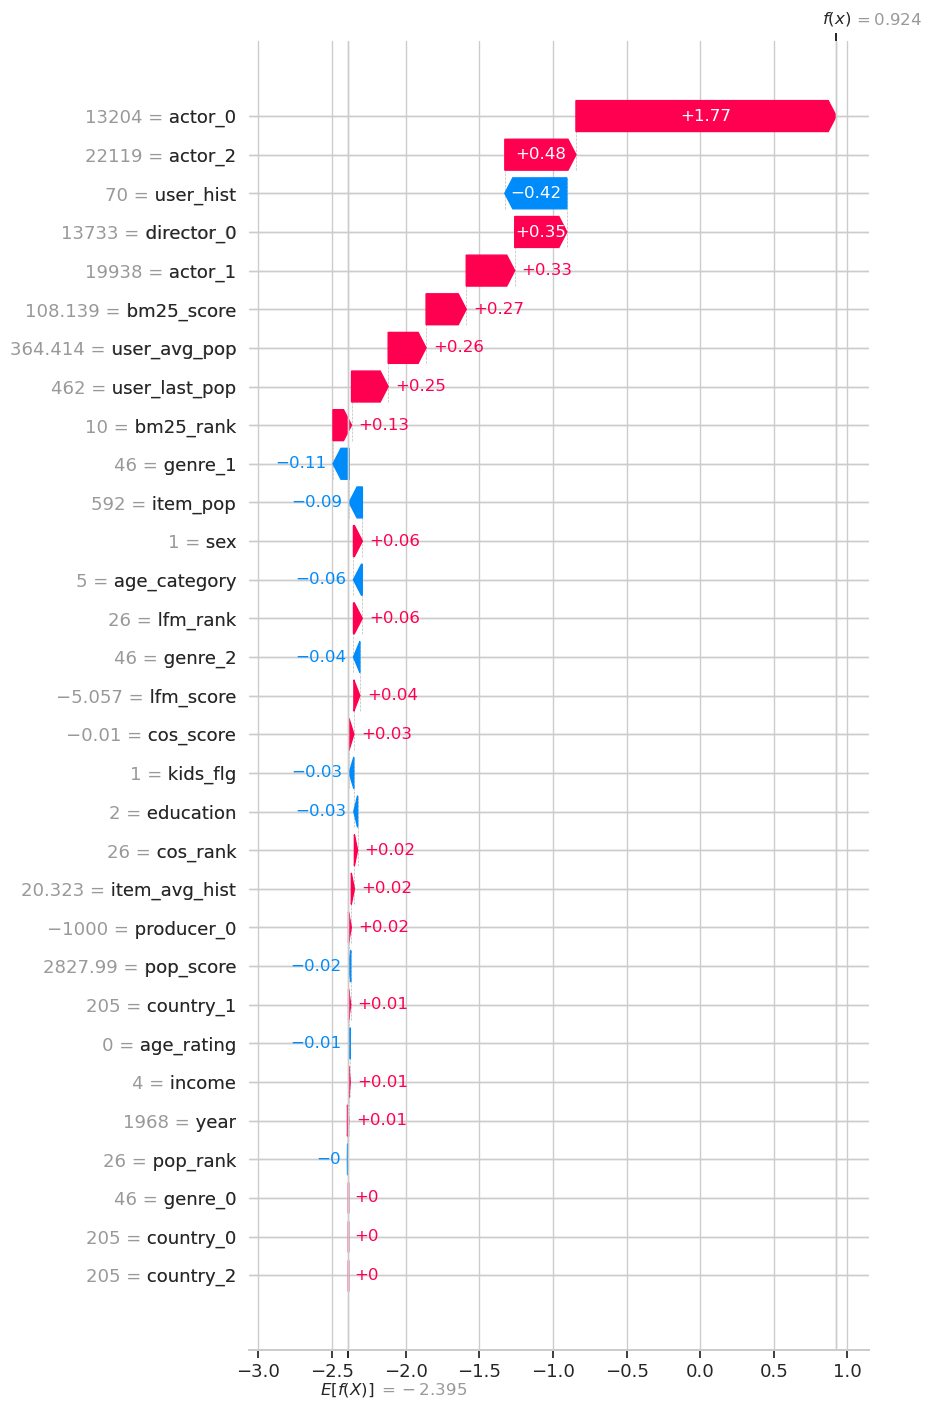

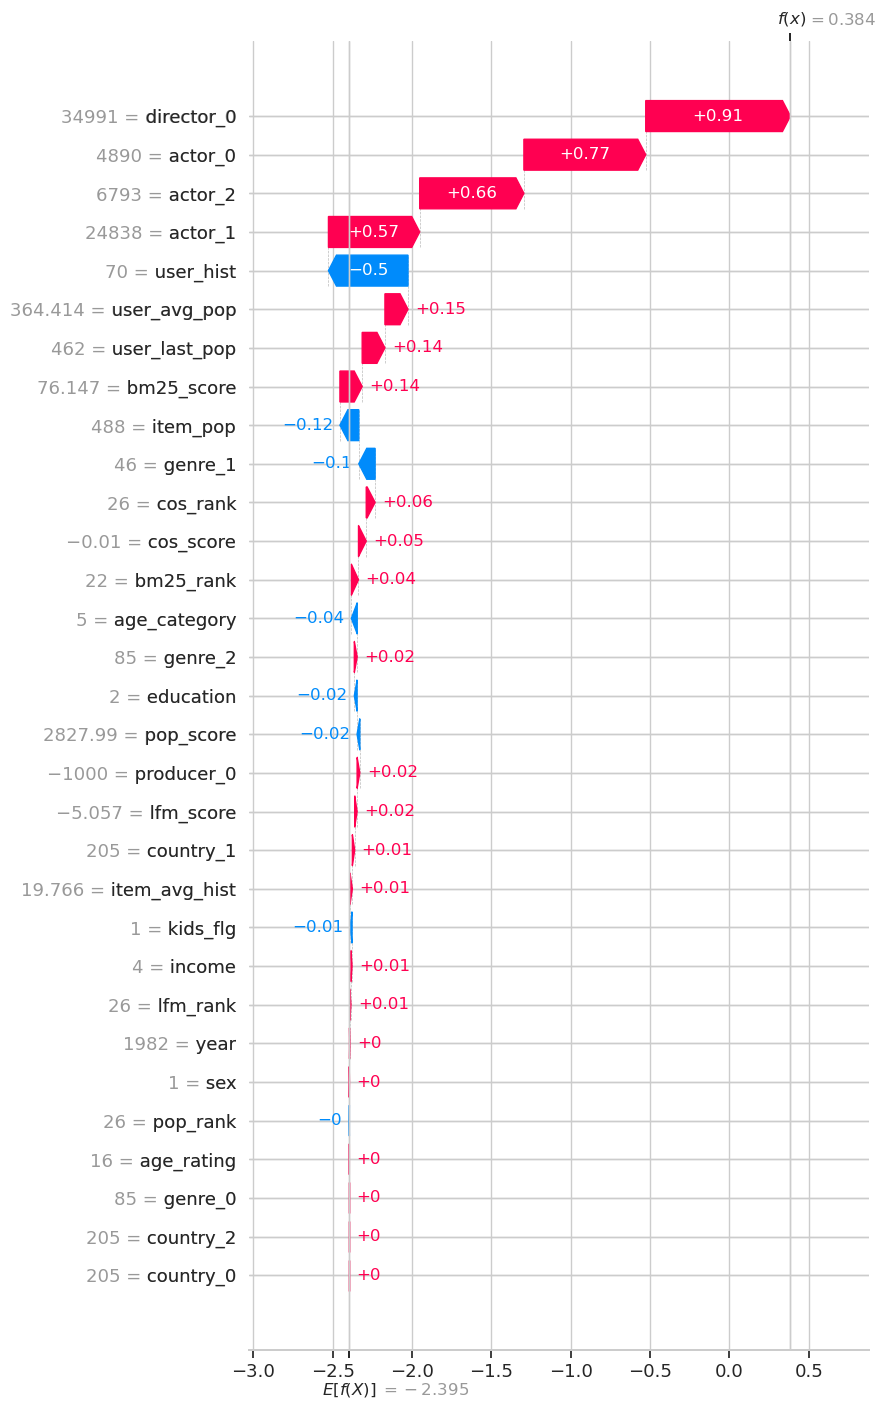

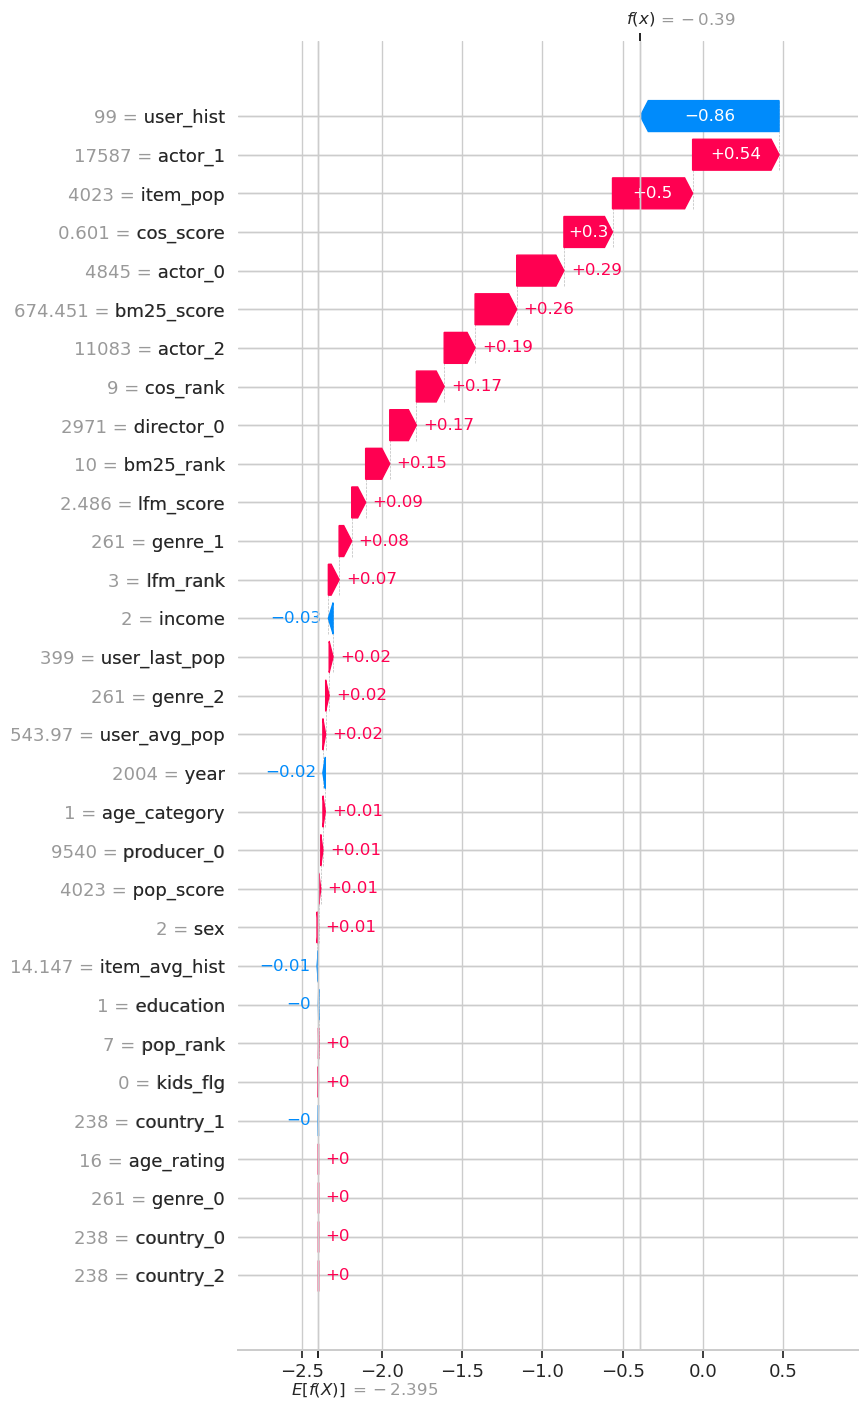

In [121]:
shap.plots.waterfall(shap_values[0], max_display=len(cols))
shap.plots.waterfall(shap_values[1], max_display=len(cols))
shap.plots.waterfall(shap_values[200], max_display=len(cols))

> **Explanation of waterfall plot from shap documentation**:
The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

>**Объяснение каскадного графика из документации shap**:
В приведенном выше пояснении показаны функции, каждая из которых способствует переходу выходных данных модели от базового значения (среднего значения, полученного моделью за прошедший набор обучающих данных) к выходным данным модели. Функции, повышающие прогноз, показаны красным цветом, а те, которые снижают прогноз, - синим.

Если обобщить значения, то получится следующий график

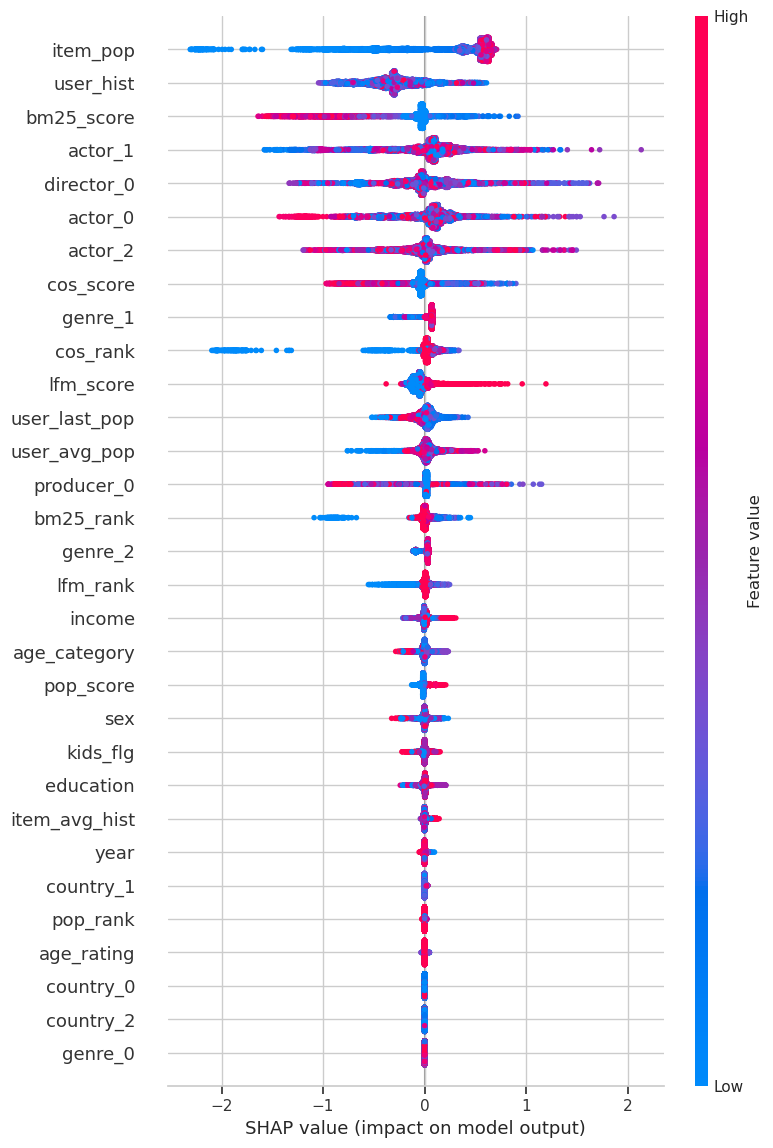

In [109]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

Он отображает вклад каждого из парамеров в решение для всех семплов на общей прямой, а
следуюций график &mdash; это его усреднение 

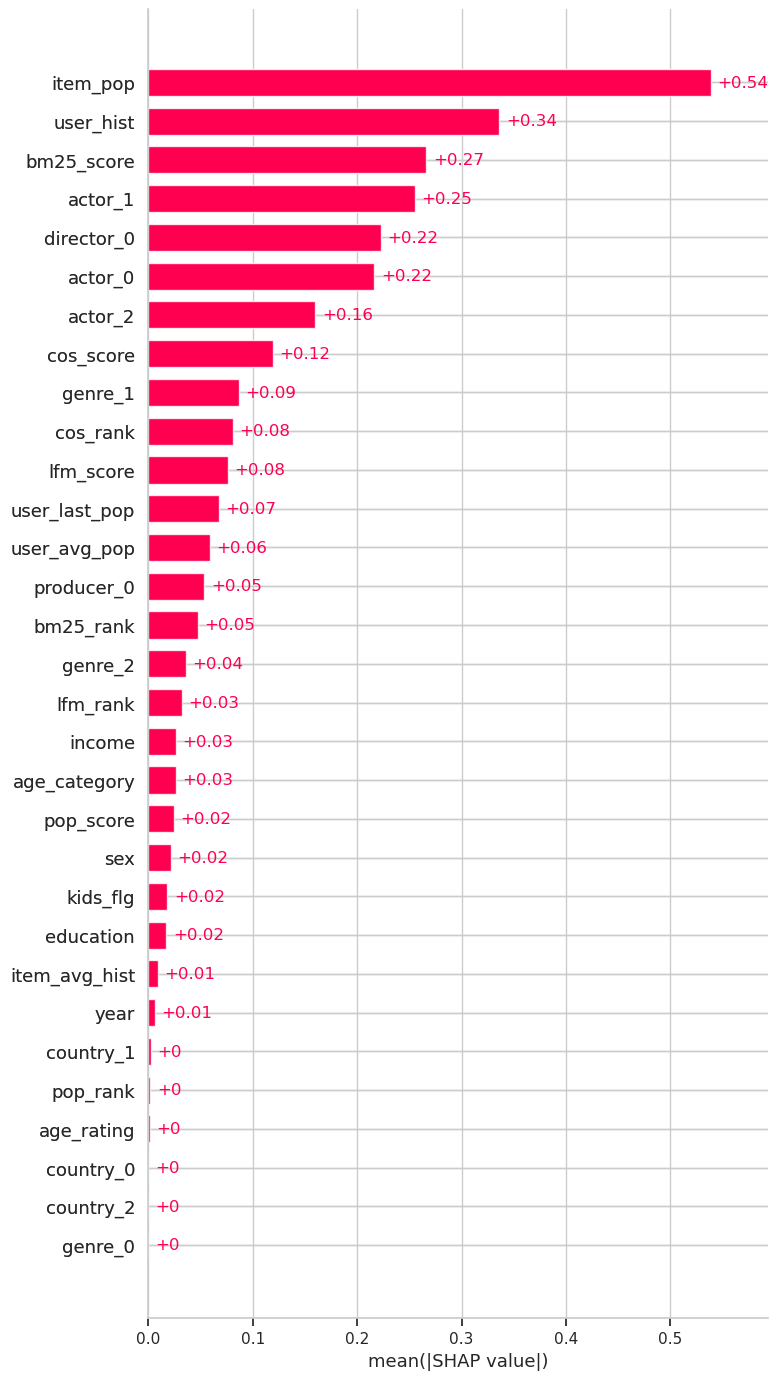

In [110]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

Так же выведем feature_importances для ранкера

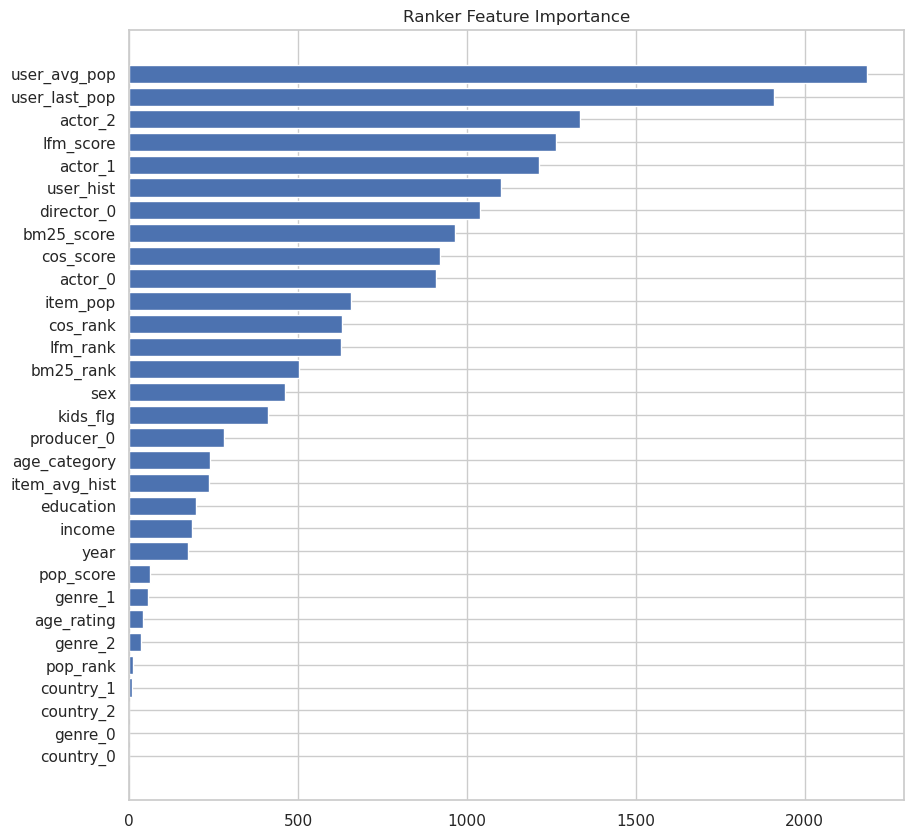

In [127]:
sorted_idx = np.argsort(listwise_model.feature_importances_)
fig = plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), listwise_model.feature_importances_[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(cols)[sorted_idx])
plt.title('Ranker Feature Importance')
plt.show()

Сильнее всего при рекомендациях влияют: 
- средняя популярность контента, просматриваемого пользователем
- популярность последнего контента, просмотренного пользователем
- актеры из каста
- история пользователя
- режисер
- скоры lfm, knn моделей

Что логично, так как это в принципе основные признаки по которым человек выбирает фильм.

История потребляемого контента &mdash; сильный призак, из которого вытаскивваются среднея и последняя популярность контента и "средний" жанр, а актеры и режисер &mdash; это те составляющие, по которым зачистую человек будет выбирать фильм, делая это в ручную.



### Выдаем рекомендации

In [111]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])

In [112]:
def add_score_and_rank(
    df: pd.DataFrame, y_pred_scores: np.ndarray, name: str
) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f"{name}_score"] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=["user_id", f"{name}_score"],
        ascending=[True, False],
        inplace=True,
    )
    df[f"{name}_rank"] = df.groupby("user_id").cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (
        (df["cos_rank"] <= 25)
        | (df["bm25_rank"] <= 25)
        | (df["lfm_rank"] <= 25)
        | (df["pop_rank"] <= 25)
    ).to_numpy()

    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f"{name}_hybrid_score"] = df[f"{name}_score"] * mask
    df[f"{name}_hybrid_score"].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f"{name}_hybrid_rank"] = df[f"{name}_rank"] * mask
    max_rank: int = 101
    df[f"{name}_hybrid_rank"].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [113]:
ranker_test = add_score_and_rank(ranker_test, y_pred, "listwise")
ranker_test.head(3)

,datetime,user_id,item_id,duration,weight,cos_score,cos_rank,bm25_score,bm25_rank,lfm_score,...,actor_2,director_0,producer_0,item_pop,item_avg_hist,target,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
44,2023-04-29 12:18:05.628376064+03:00,0,5052,0.0,0.0,-0.01,26.0,108.139183,10.0,-5.056826,...,22119,13733,-1000,592.0,20.322635,1,0.923735,1,0.923735,1
43,2023-04-29 12:18:05.628376064+03:00,0,4854,0.0,0.0,-0.01,26.0,76.146584,22.0,-5.056826,...,6793,34991,-1000,488.0,19.766393,1,0.384371,2,0.384371,2
30,2023-04-29 12:18:05.628376064+03:00,0,3477,0.0,0.0,-0.01,26.0,103.407654,11.0,-5.056826,...,33770,6956,-1000,517.0,24.502901,1,-0.301086,3,-0.301086,3


### Считаем метрики

In [114]:
predictions = (
    ranker_test[ranker_test["listwise_hybrid_rank"] <= 10][["user_id", "item_id"]]
    .groupby(by="user_id")["item_id"]
    .apply(list)
    .reset_index()
    .rename(columns={"item_id": "listwise_hybrid_rank_recs"})
)
predictions

,user_id,listwise_hybrid_rank_recs
0,0,"[5052, 4854, 3477, 4747, 1226, 5849, 5336, 484..."
1,1,"[484, 1978, 728, 5918, 4991, 5707, 5774, 7173,..."
2,2,"[4176, 3509, 3146, 5571, 4340, 1451, 1996, 358..."
3,3,"[4340, 5571, 1226, 3620, 3896, 1014, 2820, 145..."
4,4,"[65, 7401, 6592, 5707, 2280, 4229, 4061, 7124,..."
...,...,...
66895,176506,"[3044, 1281, 3583, 5849, 1430, 3311, 641, 6142..."
66896,176519,"[5118, 5849, 2820, 1098, 641, 1281, 6194, 2409..."
66897,176525,"[641, 5849, 4859, 484, 6194, 5336, 2820, 687, ..."
66898,176531,"[4991, 5849, 5918, 641, 484, 1978, 1281, 2480,..."


In [115]:
test_df = pd.merge(test_df, predictions, how="left", on="user_id")
test_df.head(3)

,user_id,movie_id,cos_recs,bm25_recs,lfm_recs,pop_recs,listwise_hybrid_rank_recs
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ...","[870, 3315, 3699, 6013, 107, 2869, 5286, 190, ...","[3315, 107, 6013, 870, 2869, 6136, 3699, 4207,...","[107, 6746, 6688, 3893, 840, 6136, 282, 2034, ...","[484, 6194, 2679, 5876, 5336, 2074, 2820, 5707...","[5052, 4854, 3477, 4747, 1226, 5849, 5336, 484..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215....","[3135, 5003, 5924, 2447, 4623, 484, 1647, 6394...","[3135, 5924, 6394, 4623, 2447, 5003, 6360, 589...","[484, 1978, 5918, 2074, 5876, 3135, 2679, 3493...","[484, 6194, 2679, 5876, 5336, 2074, 2820, 5707...","[484, 1978, 728, 5918, 4991, 5707, 5774, 7173,..."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ...","[5466, 3896, 3583, 138, 2224, 1226, 1451, 4340...","[5466, 6145, 138, 5056, 3583, 5542, 1898, 1847...","[2820, 1226, 5021, 1451, 4340, 3583, 5571, 546...","[484, 6194, 2679, 5876, 5336, 2074, 2820, 5707...","[4176, 3509, 3146, 5571, 4340, 1451, 1996, 358..."


In [116]:
evaluate_recommender(test_df, model_preds_col="listwise_hybrid_rank_recs")

{'ndcg': 0.17476980209830473, 'recall': 0.09128829855502137}

# Выводы

И так, получилось выбить хорошие `ndcg` и `recall`, но стоит отметить, что модели достаточно долго обучались и долго выдавали предсказания.
Конечно, стоит учитывать, что вычисления все произодились на локальной машине с не самыми топовыми показателями по железу, но тем неменее достаточными, чтобы обеспечивать нужную производительность.

Как вариант решения данной проблемы &mdash; это упрощение модели первой ступени. Для данного решения был выполнен ансамбль моделей дающих кандидатов для переранжирвоания: 
- KNN Cosine
- KNN BM25
- LightFM
- PopularModel

Возможно стоит оставить лишь одну из них, дающую лучшие показатели, как в весе самой модели (непосредственно память, занимаемая моделью на устройстве) и скорости работы, так и выдаваемом ей скоре в необходимых метриках. 
Таким образом можно проверить модели:
- KNN Cosine + Ranker
- KNN BM25 + Ranker
- LightFM + Ranker

Скорость будет достигаться за счет сокращения размерности матрицы, подаваемой на вход ранкеру (которую не надо будет собирать для различных кандидатов, а после мерджить).

Также можно попробовать использовать другой ранкер, например заменить используемую библиотеку `LightGBM` на `CatBoost`. В моем случае, это не подойдет: `CatBoost` на моем железе работает стабильно медленнее `LightGBM`. 

Если рассматривать выкат модели в прод, то я бы предпочел связку KNN Cosine + Ranker, т.к. модель KNN легковесная и достаточно быстро выдает рекомендуемых кандидатов, что является важным фактором при увеличении размерности задачи (числа пользователей) и циклах переобучения модели на свежих данных, накопленных за больший промежуток времени.
